# Exercise 9: Stochastic Optimization

The Nebenhoerers (Danijar Hafner, Thomas Kellermeier, Patrick Kuhn, Jan Szynal)

## What will we do?

- Inference on a small hopfield network.
- Energy-based optimization.
- **Simulated Annealing** tries random parameters, preferring better ones.
- **Mean-Field Annearling** ...
- Comparison of both methods.

In [1]:
%matplotlib inline

import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import glob
import itertools

## Hopfield/RBM?

- Uni-directional connections: $w_{ij}=w_{ji}$ and no self-connections: $w_{ii}=0$.
- We want to sample from the learned distribution, weights fixed.

![](http://deeplearning.net/tutorial/_images/rbm.png)

In [2]:
def random_weight(n, seed=0):
    random = np.random.RandomState(seed)
    # Value range.
    w = random.rand(n, n) * 2 - 1
    # Symmetric.
    w = (w + w.T) / 2
    # Zero diagonal.
    w *= (1 - np.eye(n))
    return w

## Plotting Helper (Not Too Interesting)

In [3]:
class EnergyPlot:
    
    def __init__(self, name):
        self.fig, self.ax = plt.subplots(nrows=2, figsize=(13, 7))
        self.ax[0].set_title('{} Energy'.format(name))
        self.ax[0].set_xlabel('Iteration')
        self.ax[0].set_ylabel('E(s)')
        self.ax[1].set_title('Temperature')
        self.ax[1].set_xlabel('Iteration')
        self.ax[1].set_ylabel(r'$\beta^{-1}$')
        self._labelled = False

    def __call__(self, costs, betas, label=None):
        if label:
            self._labelled = True
        self.ax[0].plot(np.arange(len(costs)), costs, label=label)
        temps = [1 / x for x in betas]
        self.ax[1].step(np.arange(len(temps)), temps)

    def show(self):
        if self._labelled:
            self.ax[0].legend()
        self.fig.tight_layout()
        plt.show()

## Annealing Methods for Optimization

- Parameters are called state $s$, cost is called energy $E(s)$; by analogy to metal annealing.
- Iteratively improve the state, starting from random.
- Temperature parameter $\frac{1}{\beta}$ defines randomness of the improvement, decays over time.

In [4]:
class Annealing:

    def __init__(self, seed=0):
        self._seed = seed

    def __call__(self, weight, epochs, beta, tau, **kwargs):
        self._init_random()
        costs, betas = [], []
        state = self._initial_state(weight.shape[0])
        for _ in range(epochs):
            state = self._update(state, weight, beta, **kwargs)
            costs.append(self._energy(state, weight))
            betas.append(beta)
            beta *= tau
        return state, costs, betas

    def _update(self, state, weight, beta, **kwargs):
        raise NotImplementedError

    def _energy(self, state, weight):
        return -0.5 * (np.outer(state, state) * weight).sum()

    def _initial_state(self, length):
        return np.array([-1, 1])[self._random.randint(0, 2, length)]
   
    def _init_random(self):
        self._random = np.random.RandomState(self._seed)

## Simulated Annealing

- Randomly modify the current state $s$.
- Modifications $s'$ that decrease the energy more are more likely.

$$P(s)=\frac{1}{1+e^\frac{\Delta E}{T}}$$

- Sample probability and decide to keep $s$ or switch to $s'$.
- Temperature moves probabilities toward uniform if high, decays over time.

two graphs

Example:

![](https://upload.wikimedia.org/wikipedia/commons/d/d5/Hill_Climbing_with_Simulated_Annealing.gif)

iterations   1, cost -3.730, result [ 1  1  1  1 -1  1]
iterations 500, cost -3.730, result [-1 -1 -1 -1  1 -1]


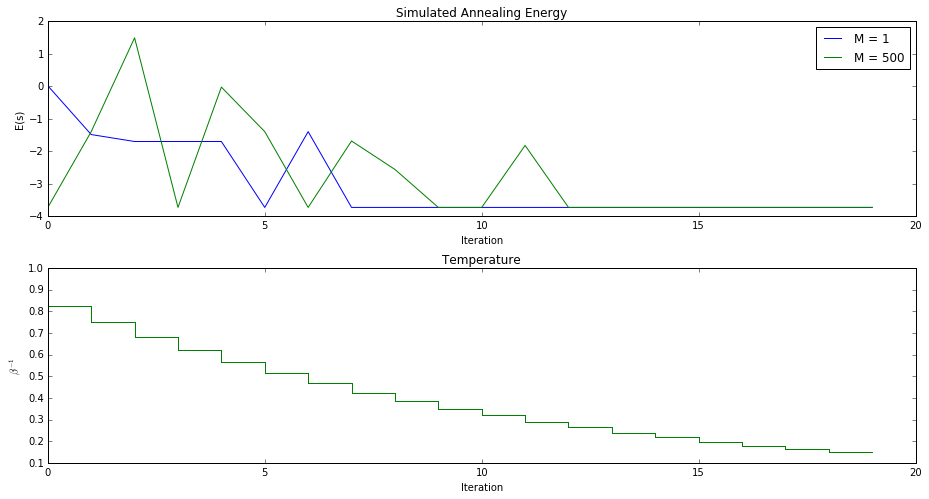

In [5]:
class SimulatedAnnealing(Annealing):
    
    def _update(self, state, weight, beta, iters=1):
        for _ in range(iters):
            node = self._random.randint(0, state.shape[0])
            delta_energy = -2 * self._local_energy(state, weight, node)
            probability = self._probability(delta_energy, beta)
            if self._random.rand() < probability:
                state[node] *= -1
        return state

    @staticmethod
    def _probability(delta_energy, beta):
        return 1 / (1 + np.e ** (beta * delta_energy))

    @staticmethod
    def _local_energy(state, weight, node):
        return -0.5 * (state[node] * state * weight[node]).sum()


def main():
    weight = random_weight(6)
    annealing = SimulatedAnnealing()
    plot = EnergyPlot('Simulated Annealing')
    for iters in (1, 500):
        state, costs, betas = annealing(weight, epochs=20, beta=1.1, tau=1.1, iters=iters)
        plot(costs, betas, 'M = {}'.format(iters))
        print('iterations {:>3}, cost {:5.3f}, result {}'.format(iters, costs[-1], state))
    plot.show()

main()

Results:

- Current states get lower energy over time, as the temperature decreases.
- $M=500$ tries more states and finds the optimal state faster.
- Both $M=1$ and $M=500$ find the optimum.

## Mean Field Annealing

Basic ideas:

- One
- Two
- Three

cost 4.158, result [ 0.99997917 -1.          0.99999997 -0.99998747  1.          0.99999779]


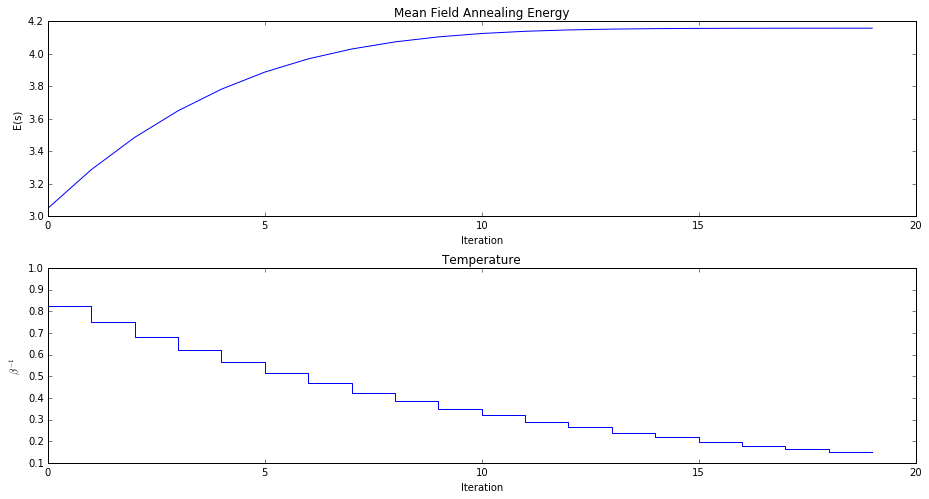

In [6]:
class MeanFieldAnnealing(Annealing):

    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self._epsilon = epsilon

    def _update(self, state, weight, beta):
        history = collections.deque(maxlen=2)
        while not self._convergence(history):
            field = -np.dot(weight, state)
            state = np.tanh(-beta * field)
            history.append(field)
        return state
    
    def _convergence(self, history):
        if len(history) < 2:
            return False
        change = np.absolute(history[0]) - np.absolute(history[1])
        return (np.absolute(change) < self._epsilon).all()


def main():
    weight = random_weight(6)
    annealing = MeanFieldAnnealing()
    plot = EnergyPlot('Mean Field Annealing')
    state, costs, betas = annealing(weight, epochs=20, beta=1.1, tau=1.1)
    plot(costs, betas)
    print('cost {:5.3f}, result {}'.format(costs[-1], state))
    plot.show()

main()